# Competition: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)


copyright: abhirup.ghosh.184098@gmail.com

### Kaggle dependencies

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


### Dependencies

In [2]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex3 import *

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

## Competition Data

In [3]:
comp_dir = Path('../input/store-sales-time-series-forecasting')

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = store_sales.groupby('date').mean()['sales']

In [4]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()


# YOUR CODE HERE: Create a time dummy
time = np.arange(len(df.index))

df['time'] = time 

# YOUR CODE HERE: Create training data
X = df.loc[:, ['time']] # features
y = df.loc[:, 'sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

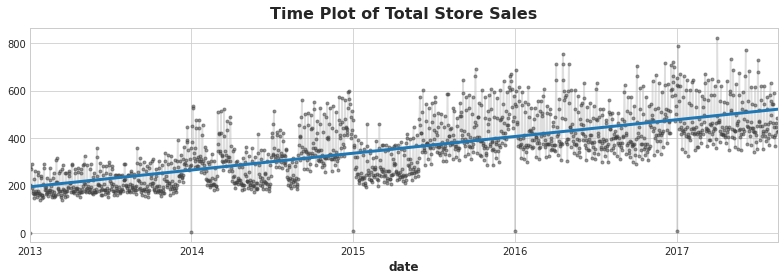

In [5]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

In [6]:
df = average_sales.to_frame()

# YOUR CODE HERE: Create a lag feature from the target 'sales'
lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1  # add to dataframe

X = df.loc[:, ['lag_1']].dropna()  # features
y = df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# YOUR CODE HERE: Create a LinearRegression instance and fit it to X and y.
model = LinearRegression()
model.fit(X, y)

# YOUR CODE HERE: Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

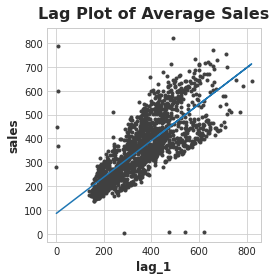

In [7]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

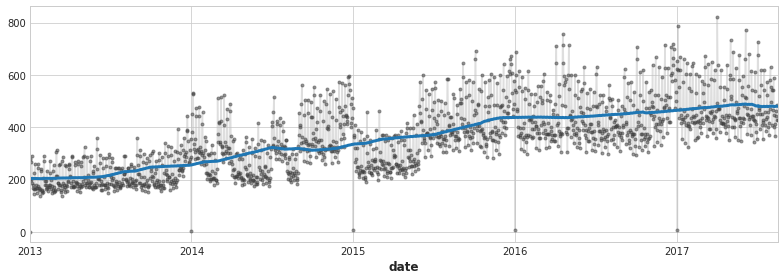

In [8]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

In [9]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()  # the target

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=average_sales.index,  # dates from the training data
    constant=False,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend): cubic trend
    drop=True,           # drop terms if necessary to avoid collinearity
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

# YOUR CODE HERE: Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

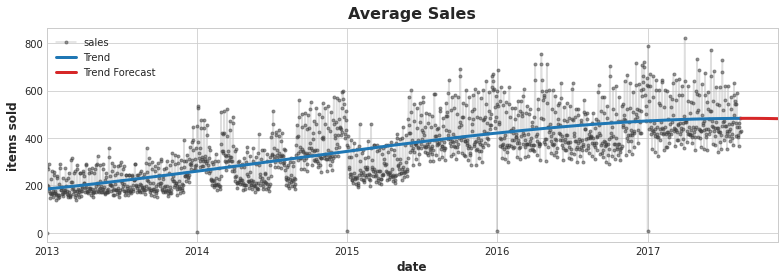

In [10]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

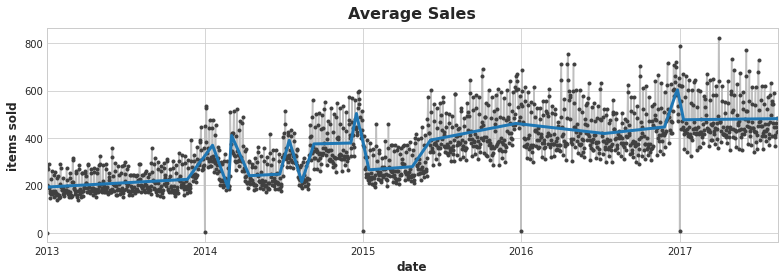

In [11]:
from pyearth import Earth

# Target and features are the same as before
y = average_sales.copy()
dp = DeterministicProcess(index=y.index, order=1)
X = dp.in_sample()

# Fit a MARS model with `Earth`
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")

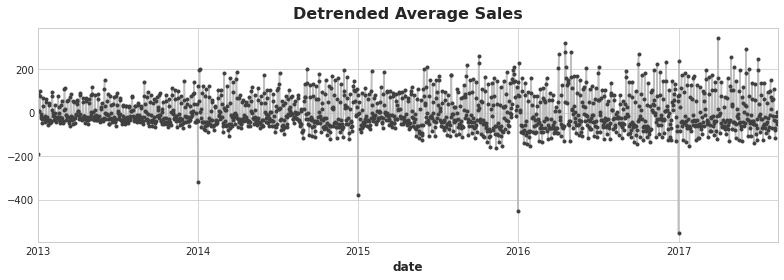

In [12]:
y_detrended = y - y_pred   # remove the trend from store_sales

y_detrended.plot(**plot_params, title="Detrended Average Sales");

In [13]:
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

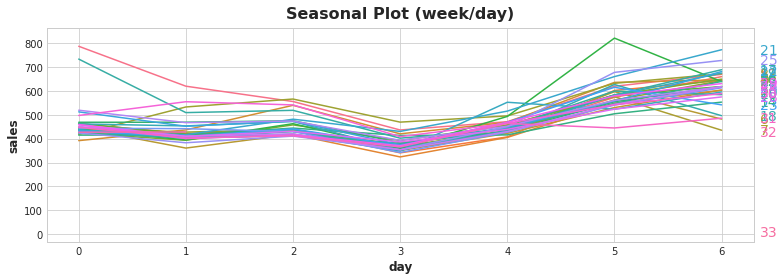

In [14]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

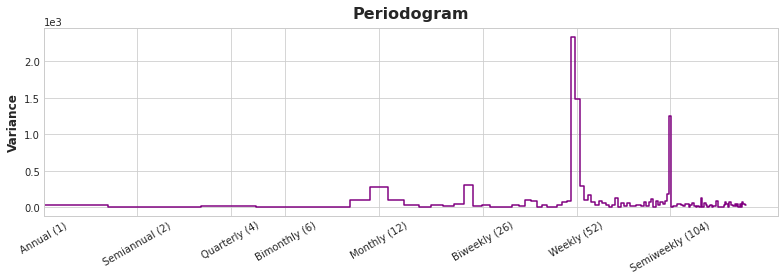

In [15]:
plot_periodogram(average_sales);

In [16]:
y = average_sales.copy()

# YOUR CODE HERE
fourier = CalendarFourier(freq="M", order=4)  # 4 sin/cos pairs for "A"nnual seasonality
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample() 

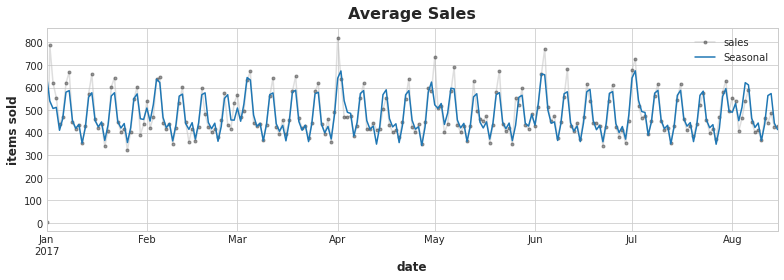

In [17]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

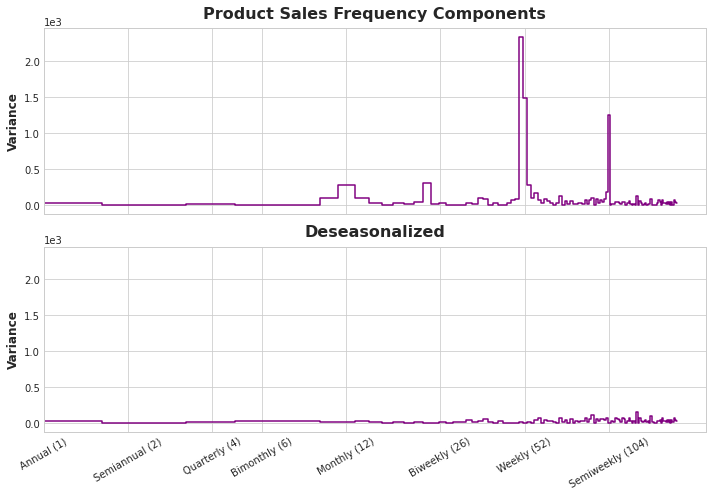

In [18]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

In [19]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


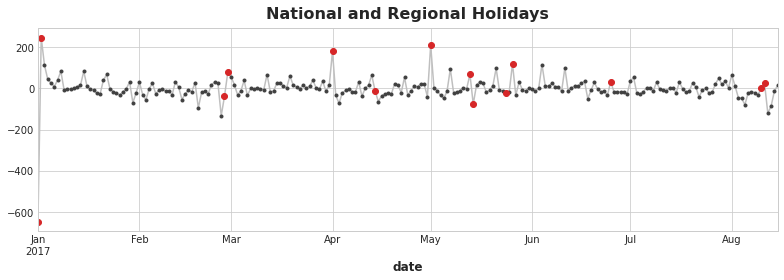

In [20]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

In [21]:
# YOUR CODE HERE
X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)

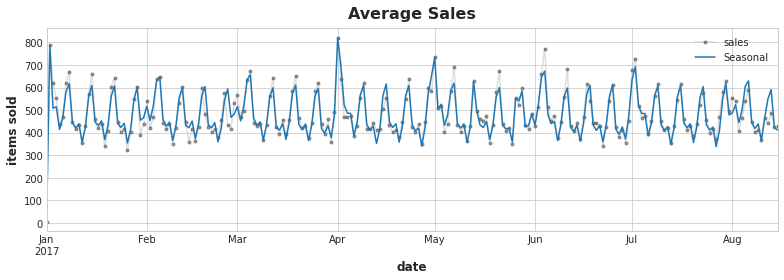

In [22]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

In [23]:
X2.columns

Index(['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=M)', 'cos(1,freq=M)', 'sin(2,freq=M)',
       'cos(2,freq=M)', 'sin(3,freq=M)', 'cos(3,freq=M)', 'sin(4,freq=M)',
       'cos(4,freq=M)', 'description_Batalla de Pichincha',
       'description_Carnaval', 'description_Dia de la Madre',
       'description_Dia de la Madre-1', 'description_Dia del Trabajo',
       'description_Primer Grito de Independencia',
       'description_Primer dia del ano',
       'description_Provincializacion de Cotopaxi',
       'description_Provincializacion de Imbabura',
       'description_Traslado Batalla de Pichincha',
       'description_Traslado Primer Grito de Independencia',
       'description_Traslado Primer dia del ano', 'description_Viernes Santo'],
      dtype='object')

In [24]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test = X_test.join(X_holidays, on='date').fillna(0.0)
#X_test['NewYear'] = (X_test.index.dayofyear == 1)

y = y.to_frame()

y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
#y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)